##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2021-11-03 09:23:00--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bmild.com/nerf/tiny_nerf_data.npz [following]
--2021-11-03 09:23:01--  https://bmild.com/nerf/tiny_nerf_data.npz
Resolving bmild.com (bmild.com)... 216.239.38.21, 216.239.32.21, 216.239.36.21, ...
Connecting to bmild.com (bmild.com)|216.239.38.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bmild.github.io/nerf/tiny_nerf_data.npz [following]
--2021-11-03 09:23:01--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.108.153|:443... connected.
HTTP re

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


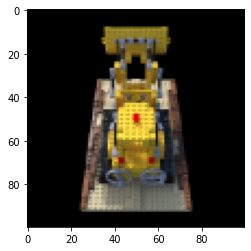

In [55]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[102], poses[102]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [56]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc


def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    posenc = tf.keras.Input(shape=(3 + 3*2*L_embed), dtype='float32') 
    direnc = tf.keras.Input(shape=(3 + 3*2*L_embed), dtype='float32') 

    outputs = posenc
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, posenc], -1)
    sigma = dense(1, act=None)(outputs)

    outputs = tf.concat([outputs, direnc], -1)
    outputs = dense()(outputs)
    rgb = dense(3, act=None)(outputs)
    
    model = tf.keras.Model(inputs=[posenc, direnc], outputs=[sigma, rgb])

    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def feedforward(fn, pos, dir, chunk=1024*32):
    sigma_out = tf.zeros((0, 1))
    rgb_out = tf.zeros((0, 3))
    for i in range(0, pos.shape[0], chunk):
        pred = fn([pos[i:i+chunk], dir[i: i+chunk]], training=True)
        sigma_out = tf.concat([sigma_out, pred[0]], axis=0)
        rgb_out = tf.concat([rgb_out, pred[1]], axis=0)
    return sigma_out, rgb_out


def generate_rays(rays_o, rays_d, near, far, N_samples, rand=True):


    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      bounds = tf.linspace(near, far, N_samples+1)
      z_vals = tf.zeros((rays_o.shape[0], rays_o.shape[1], 0))
      for i in range(N_samples):
        layer = tf.random.uniform(shape=(rays_o.shape[0], rays_o.shape[1], 1), minval = bounds[i], maxval = bounds[i+1])
        z_vals = tf.concat([z_vals, layer], axis=2)
      # z_vals = z_vals[:, :, 1:]

    
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    dirs = rays_d[..., None,:]
    dirs = tf.repeat(dirs, repeats=[64], axis=2)

    pts_flat = tf.reshape(pts, [-1,3])
    dirs_flat = tf.reshape(dirs, [-1, 3])
    pts_flat = embed_fn(pts_flat)
    dirs_flat = embed_fn(dirs_flat)
    return pts_flat, dirs_flat, z_vals

def run_model(network_fn, pts_flat, dirs_flat, z_vals, img_shape):
    sigma, rgb = feedforward(network_fn, pts_flat, dirs_flat)
    sigma = tf.reshape(sigma, list(img_shape[:-1]))
    rgb = tf.reshape(rgb, list(img_shape[:-1]) + [3])
    
    
    # Compute opacities and colors
    sigma = tf.nn.relu(sigma)
    rgb = tf.math.sigmoid(rgb) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map



Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.09222089767456054 secs per iter


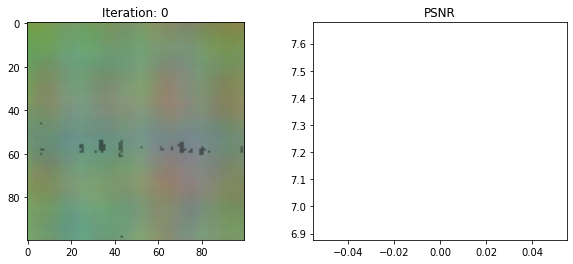

25 2.027343635559082 secs per iter


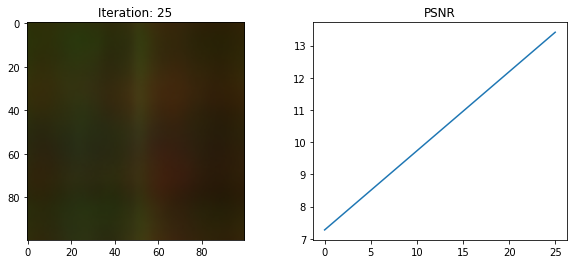

50 2.0354016971588136 secs per iter


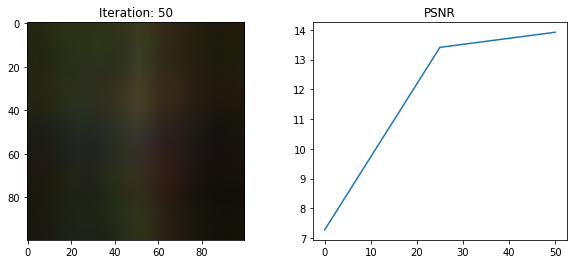

75 2.022896327972412 secs per iter


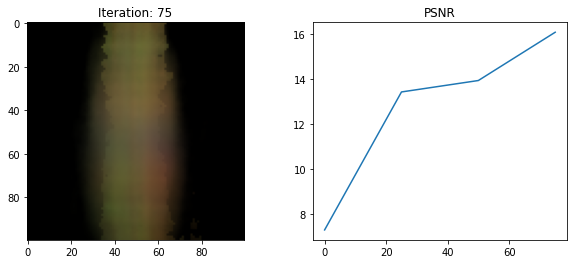

100 2.003336162567139 secs per iter


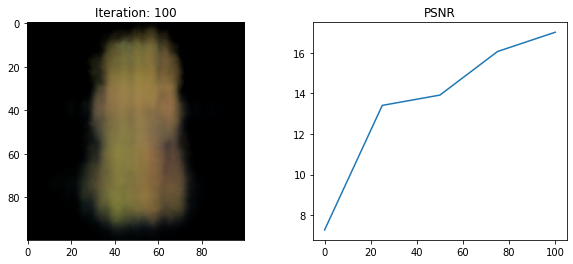

125 2.0071935272216797 secs per iter


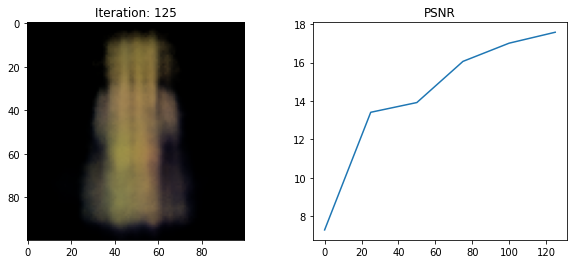

150 1.99582275390625 secs per iter


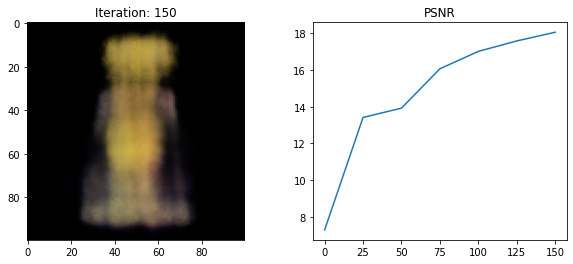

175 2.00032753944397 secs per iter


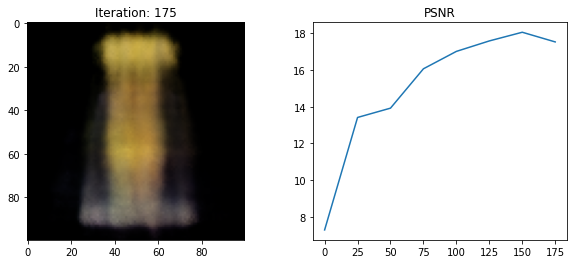

200 1.9995219326019287 secs per iter


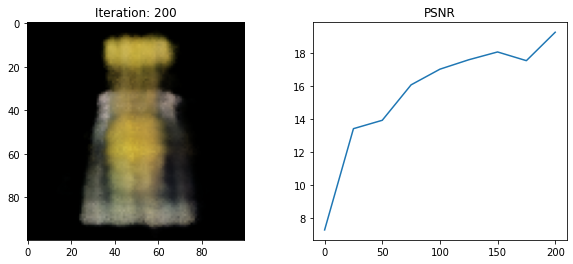

225 2.000769004821777 secs per iter


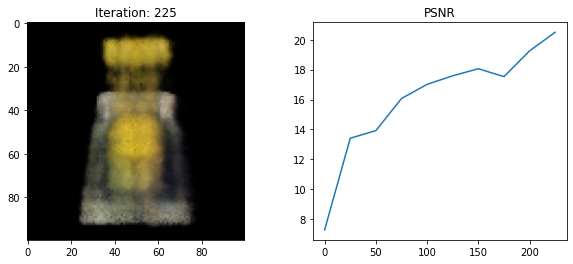

250 1.9973318195343017 secs per iter


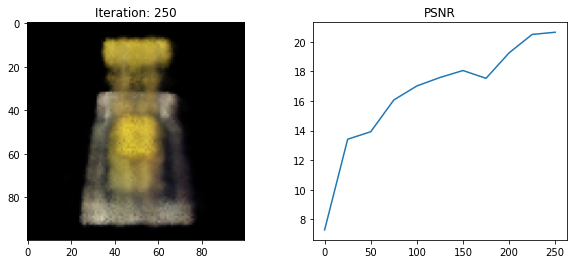

275 1.9953318691253663 secs per iter


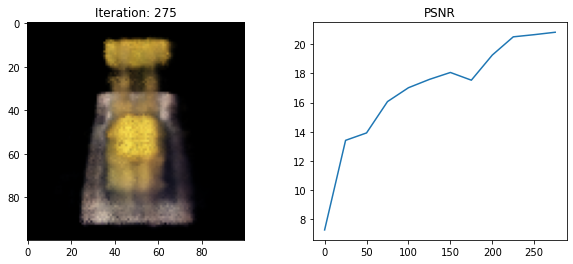

300 1.9977382183074952 secs per iter


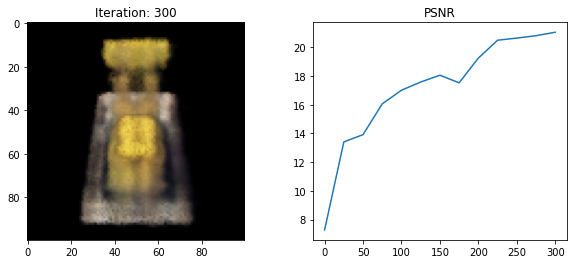

325 1.9990210342407226 secs per iter


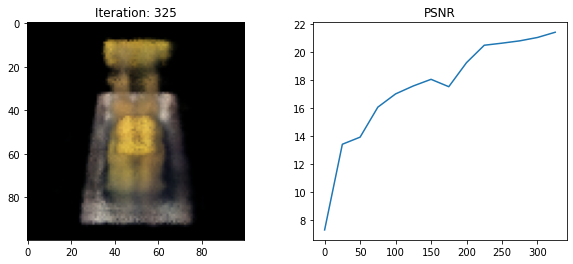

350 1.9966477584838866 secs per iter


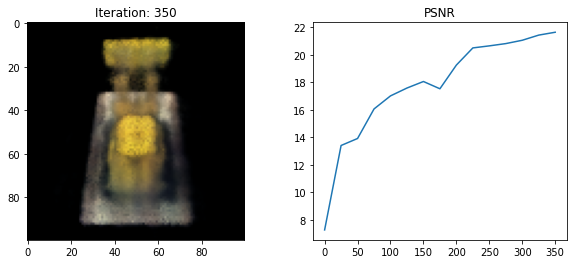

375 1.9972926330566407 secs per iter


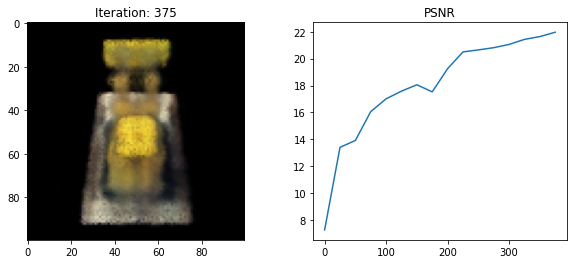

400 1.9983253479003906 secs per iter


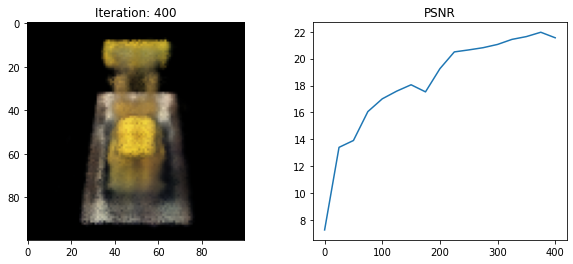

425 1.993637638092041 secs per iter


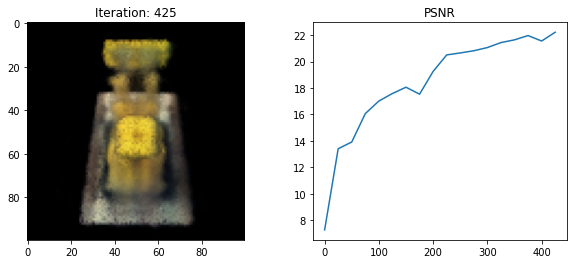

450 2.0020897674560545 secs per iter


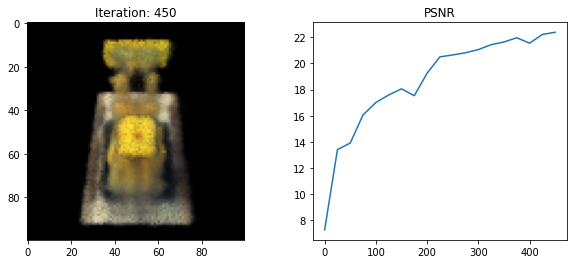

475 1.9977125167846679 secs per iter


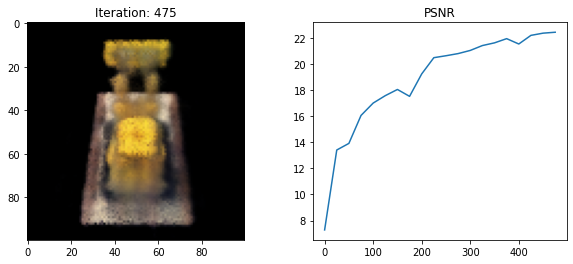

500 2.0008183670043946 secs per iter


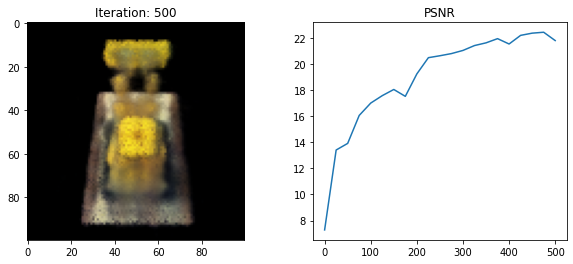

Done


In [57]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 500
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    img_shape = list(target.shape[:-1])+[64, 1]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    pts_flat, dirs_flat, z_vals = generate_rays(rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)

    with tf.GradientTape() as tape:

        rgb, depth, acc = run_model(model, pts_flat, dirs_flat, z_vals, img_shape)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        pts_flat, dirs_flat, z_vals = generate_rays(rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        rgb, depth, acc = run_model(model, pts_flat, dirs_flat, z_vals, img_shape)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:

bins = 
fluxes = weights
prob = fluxes /float(sum(fluxes))
cum_prod = np.cumsum(prob) 
Nf = 128
R = ra.unform(0,1, N)

gen bins = [int(bins[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r > 0)]))]) for r in R]

